In [1]:
import numpy as np
import itertools
import sys
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tqdm

numpy.set_printoptions(threshold=sys.maxsize)

In [2]:
chunk_file = "sub_chunk.npy"
normalize_data = True
use_dummy = True

In [3]:
the_chunk = np.load(chunk_file)

In [4]:
if use_dummy:
    # Create dummy chunk
    total_elements = 4 * 4 * 4
    
    # Dummy chunk of consecutive ints
    consecutive_integers = np.arange(total_elements)
    # consecutive_integers = np.zeros(total_elements)
    
    # Reshape the 1D array
    the_chunk = consecutive_integers.reshape((4, 4, 4))

In [5]:
# Normalize the chunk data
if normalize_data:
    # Save original shape
    original_shape = the_chunk.shape
    
    # Reshape to 2D array with one column
    reshaped_chunk = the_chunk.reshape(-1, 1)
    
    # Apply scalar
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_chunk = scaler.fit_transform(reshaped_chunk)
    
    # Reshape 
    the_chunk = scaled_chunk.reshape(original_shape)

In [6]:
print(the_chunk.shape)
sub_chunk_size = 2

(4, 4, 4)


In [7]:
def get_adjacent_chunks(chunk_coords, chunk_size, total_chunk):
    # List to hold adjacent chunks
    adjacent_chunks = []

    # Select the initial chunk
    initial_chunk = total_chunk[
        chunk_coords[0]:chunk_coords[0] + chunk_size,
        chunk_coords[1]:chunk_coords[1] + chunk_size,
        chunk_coords[2]:chunk_coords[2] + chunk_size,
    ]
    
    for dim in range(len(total_chunk.shape)):
        for offset in [-1, 1]:
            # Check if the adjacent chunk is within bounds
            if 0 <= chunk_coords[dim] + offset < total_chunk.shape[dim] - chunk_size + 1:
                # Creating the indexer for the adjacent chunk
                indexer = [
                    slice(chunk_coords[i], chunk_coords[i] + chunk_size) 
                    for i in range(3)
                ]
                # Adjust the slice for the specific dimension
                indexer[dim] = slice(chunk_coords[dim] + (offset*chunk_size), chunk_coords[dim] + (offset*chunk_size) + chunk_size)
                
                # Getting the adjacent chunk
                adjacent_chunk = total_chunk[tuple(indexer)]
                adjacent_chunks.append((rotate_chunk(initial_chunk, dim, offset).flatten(), adjacent_chunk.flatten()))
            

    return adjacent_chunks
                    

In [8]:
def rotate_chunk(chunk, dim, offset):
    # Axis mapping for rotation based on the dimension
    axis_map = {0: (1, 2), 1: (0, 2), 2: (0, 1)}

    # Rotate the chunk
    # The number of rotations (k) and whether to flip is determined by the offset
    k = 1 if offset == 1 else 3  # 90 degrees clockwise or 270 degrees (90 counter-clockwise)
    rotated_chunk = np.rot90(chunk, k=k, axes=axis_map[dim])

    # Flip the chunk if the offset is -1
    if offset == -1:
        flip_axis = axis_map[dim][0]
        rotated_chunk = np.flip(rotated_chunk, axis=flip_axis)

    return rotated_chunk

In [9]:
slices = [range(0, s, sub_chunk_size) for s in the_chunk.shape]
chunk_data = []

# Iterate over all combinations of slices
for indices in itertools.product(*slices): 
    chunk_data.extend(get_adjacent_chunks(chunk_coords=indices, chunk_size=sub_chunk_size, total_chunk=the_chunk))

In [10]:
# Check the datast for uniqueness
in_out_dict = {}

for in_data, out_data in chunk_data:

    
    # Converto to hashable tuple
    in_data_tuple = tuple(in_data)
    out_data_tuple = tuple(out_data)

    # If the input is already mapped
    if in_data_tuple in in_out_dict:
        if out_data_tuple != in_out_dict[in_data_tuple]:
            print(f"Non unique output: {in_data_tuple} maps to [{in_out_dict[in_data_tuple]}, {out_data_tuple}]")
    else:
        in_out_dict[in_data_tuple] = out_data_tuple

In [11]:
hidden_layer_size_scale = 1

class SimpleFFN(nn.Module):
    def __init__(self, input_size):
        hidden_layer_size = round(input_size * hidden_layer_size_scale)
        print(f"hidden_layer_size={hidden_layer_size}")
        super(SimpleFFN, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_layer_size) 
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, input_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
class ChunkDataset(Dataset):
    def __init__(self, chunk_list):
        self.data = [(torch.tensor(inp, dtype=torch.float32), torch.tensor(out, dtype=torch.float32))
                     for inp, out in chunk_list]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [13]:
def calculate_accuracy(predictions, targets, threshold=1):
    # Reshape predictions and targets for the scaler
    predictions_np = predictions.detach().numpy().reshape(-1, 1)
    targets_np = targets.detach().numpy().reshape(-1, 1)

    # Reverse the scaling
    original_predictions = torch.tensor(scaler.inverse_transform(predictions_np)).squeeze()
    original_targets = torch.tensor(scaler.inverse_transform(targets_np)).squeeze()

    # Calculate accuracy with the original values
    correct = (abs(torch.round(original_predictions) - original_targets) < threshold).sum()

    return correct.item() / predictions.numel()

In [14]:
batch_size = 64
learning_rate = .00001
epochs = 20000

# Create the dataset
dataset = ChunkDataset(chunk_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

# training metrics
training_loss = []
training_accuracy = []

In [15]:
# Determine input size from chunk_data
input_size = len(next(iter(chunk_data))[0])

model = SimpleFFN(input_size)

# Using Mean Squared Error Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train epochs
for epoch in tqdm.tqdm(range(epochs)):
    epoch_loss = 0.0
    epoch_acc = 0.0
    batch_count = 0

    for inputs, targets in dataloader:
        batch_count += 1

        # Pass data to model
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Calculate accuracy
        acc = calculate_accuracy(outputs, targets)
        epoch_acc += acc

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / batch_count
    average_epoch_acc = epoch_acc / batch_count
    training_loss.append(average_epoch_loss)
    training_accuracy.append(average_epoch_acc)

    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}, Accuracy: {average_epoch_acc:.4f}')

hidden_layer_size=8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:49<00:00, 401.15it/s]


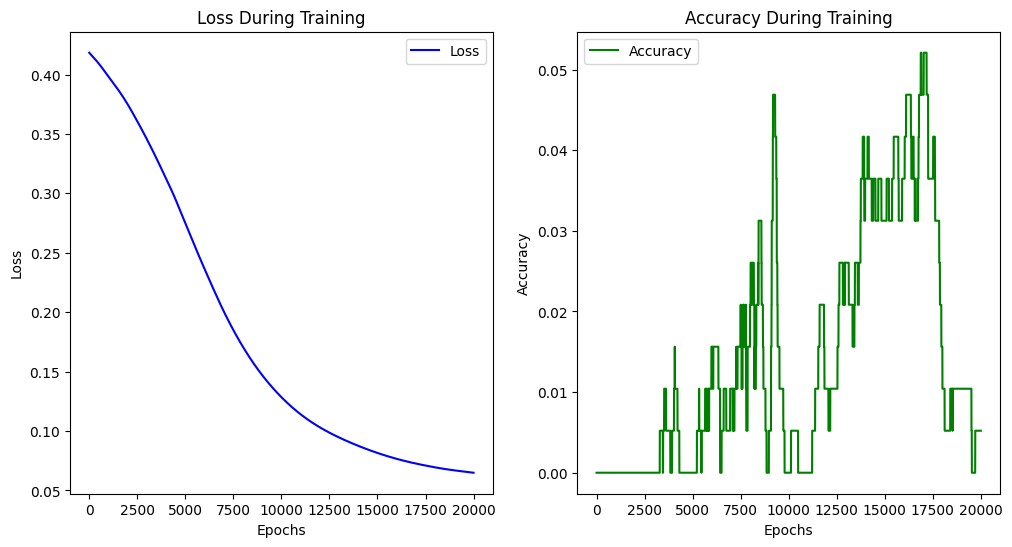

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(training_loss, label='Loss', color='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss During Training')
ax1.legend()

ax2.plot(training_accuracy, label='Accuracy', color='green')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy During Training')
ax2.legend()

plt.show()